# Playing Atari with Deep Reinforcement Learning

Paper: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

Walkthorugh: https://becominghuman.ai/lets-build-an-atari-ai-part-0-intro-to-rl-9b2c5336e0ec

# Imports

In [1]:
import numpy as np
import pandas as pd
import gym
from copy import deepcopy

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam
from keras.callbacks import History
from keras.backend import tf as ktf
from keras.callbacks import Callback as KerasCallback, CallbackList as KerasCallbackList
from keras.utils.generic_utils import Progbar

from rl.agents.dqn import DQNAgent
from rl.policy import EpsGreedyQPolicy, LinearAnnealedPolicy, Policy
from rl.memory import SequentialMemory
from rl.core import Processor

from IPython import display
from IPython.display import clear_output
import matplotlib
import matplotlib.pyplot as plt
%matplotlib notebook

%load_ext autoreload
%autoreload 2

/home/nathan/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Environment

We use Gym's environments for now (specifically, the Atari environments).  Later, we'll be able to define our own environments using Gym's API, but for now we'll just use their out of the box options.

In the paper, they use the game `Breakout` with a slightly modified behavior that 'skips' every 4 frames.  It does this because they found that they didn't gain much improvement from having the DQN make an action for every frame, and instead found that having it make an action on every 4th frame (and just repeating that action for the 4 frames) was sufficient in this environment.  Gym offers this same version of the game, which can be made using `BreakoutDeterministic-v4`.

In [2]:
env = gym.make('BreakoutDeterministic-v4') # try out different envs
env.reset()

np.random.seed(123)
env.seed(123)
nb_actions = env.action_space.n

# Agent

In order to implement a DQN, we need to start with an agent.  Instead of writing one from scratch (which is more tedious than actually difficult), we're going to adapt code from the `keras-rl` library (https://github.com/keras-rl/keras-rl).  Their DQN implementation is designed to match the same one demonstrated in the paper.  I've looked through the code (at this point quite extensively), and it's implemented the same way we would, so it's quite suitable.

## Visualizer Callback

The keras-rl default visualizer is iffy when using a server so, we'll disable the default visualizer, and create a slightly modified version that suits our purposes.  Essentially, we just get the environment to return the image of the game as an RGB numpy array, then use Matplotlib to plot it.

Visualization should only be used for debugging/demonstration.  Using visualization during training will slow it down drastically, so use with caution.

In [14]:
class Visualizer(KerasCallback):
    def __init__(self, view_machine_mode=False, show_labels=True):
        self.machine_mode = view_machine_mode
        self.show_labels = show_labels
    
    def _set_env(self, env):
        self.env = env
        self.img = plt.imshow(self.env.render(mode='rgb_array')) # only call this once
        self.frame = 0
        plt.figure(figsize = (10,10))

    def on_action_end(self, action, logs):
        """ Render environment at the end of each action """
        img = self.env.render(mode='rgb_array')
        
        if self.machine_mode:
            # This lines allow us to see what the NN sees
            img = img[::2, ::2] # downscale
            img = np.mean(img, axis=2).astype(np.uint8) # grayscale
        
        self.frame += 1
        plt.cla()
        plt.imshow(img)
        if self.show_labels:
            plt.annotate('frame : ' + str(self.frame), xy=(10, 40), color='white')
            plt.annotate('action: ' + str(action), xy=(10, 50), color='white')
            
        display.display(plt.gcf())
        display.clear_output(wait=True)

## Preprocessor

Since the environment is pre-built and the agent is pre-built, we create a keras-rl Processor to treat data according to the paper's specifications (downsample and grayscale).

Note: we could modify the environment, the agent, or both instead to do this if we needed, but keras-rl provides this API to be able to avoid that.

https://github.com/keras-rl/keras-rl/blob/master/rl/core.py

In [4]:
class AtariProcessor(Processor):      
    def process_observation(self, observation):
        # Normally, the observation is passed directly to the NN,
        # but we override this behavior to follow preprocessing steps
        img = observation 
        img = img[::2, ::2] # downscale
        img = np.mean(img, axis=2).astype(np.uint8) # grayscale
        return img

## Model

This is the model used in the paper (or as close to it as I could get).  It's a pretty straight-forward CNN.  It implements the input's normalization as a `Lambda` layer (so that we don't have to preprocess the data in that respect).

The input is actually 4 Grayscale frames, hence the input shape of `(4, 105, 80)`.  This is how it was designed in the paper (it uses the 4 most recent frames so that the DQN can figure out things like the ball's trajectory).

We also don't directly compile the model.  The keras-rl library takes care of this for us, which is important since it handles 'special' properties of the model, such as using the **Huber Loss** and the output masking.  It should be noted that we could implement these things pretty readily in the model definition (as the walkthrough describes), but we don't since we're relying on keras-rl's implementation.

In [5]:
input_shape = (4, 105, 80)

frames_input = keras.layers.Input(input_shape, name='frames')

# performs normalization directly in model
normalized = keras.layers.Lambda(lambda x: x / 255.0)(frames_input)

conv_1 = keras.layers.Conv2D(32, (8,8), strides=(4, 4), activation='relu', data_format='channels_first')(normalized)
conv_2 = keras.layers.Conv2D(64, (4,4), strides=(2, 2), activation='relu')(conv_1)
conv_3 = keras.layers.Conv2D(64, (3,3), strides=(1, 1), activation='relu')(conv_2)

conv_flattened = keras.layers.Flatten()(conv_3)
hidden = keras.layers.Dense(512, activation='relu')(conv_flattened)
output = keras.layers.Dense(nb_actions)(hidden)

model = keras.models.Model(inputs=frames_input, outputs=output)
optimizer = optimizer=keras.optimizers.RMSprop(lr=0.00025, rho=0.95, epsilon=0.01)
#model.compile(optimizer, loss='mse')

## Agent Creation

Finally, we put everything together to create the agent.  We need three things to actually create the agent: it's memory, it's policy, and it's model.  We created the model above, and keras-rl provides us with suitable classes for memory and policy.

The memory we'll be using is `Sequential Memory`, which works as described in the paper.  Note that we're using a `window_length` of 4, to reflect the 4 frames of information we need as described before.

The policy we'll be using for training is `EpsGreedyQPolicy` setup with `LinearAnnealedPolicy`.  The `EpsGreedyPolicy` is the ε-Greedy policy as described in the paper (it chooses a random action with a proportionate frequency to ε).  The `LinearAnnealedPolicy` is a class wrapper that anneals the ε value in the ε-Greedy policy (as described in the paper).

Finally, we put all this together in an instance of the DQNAgent class.  We pass through all of it's components, then compile it.

In [6]:
memory = SequentialMemory(limit=50000, window_length=4)
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), 'eps', 1., 0.1, 0, 1000000)
dqn = DQNAgent(model=model, processor=AtariProcessor(), nb_actions=nb_actions, 
               memory=memory, nb_steps_warmup=10, target_model_update=1e-2, policy=policy)
dqn.compile(optimizer, metrics=['mse'])

# Training

Finally, we can train the thing.  As mentioned above, we can add the `Visualizer` callback to the `fit` method to plot the image and set `visualize` to `False`.  We set `action_repetition` to 4 so that the agent only acts on every 4th frame.  The model's `fit` method returns the training history, so we can look at that later by saving to the `hist` variable.

After training has completed, we save the weights of the model (note: this will overwrite previous models.  If you want to save previous models, either move them or save the new one to a different path).

done, took 15.469 seconds


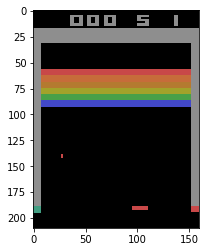

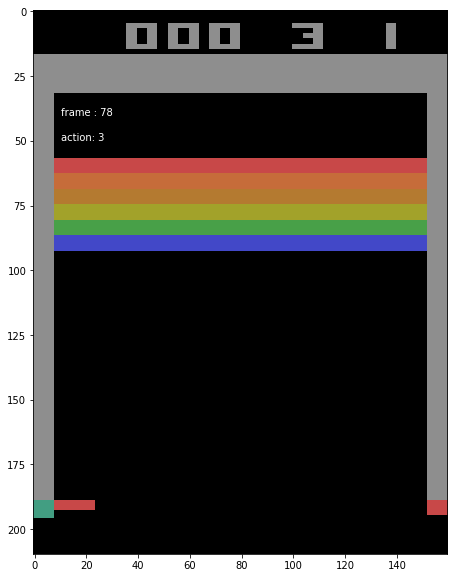

In [15]:
callbacks = []
callbacks = [Visualizer()]

hist = dqn.fit(env, nb_steps=500000, visualize=False, action_repetition=4,
               callbacks=callbacks, verbose=2)

# After training is done, we save the final weights
dqn.save_weights('dqn_{}_weights.h5f'.format('test'), overwrite=True)

# Testing

Here, we run the actual DQN in a test environment. There are a couple of things to note:

The `test` method doesn't necessarily use the same policy as the `fit` method.  It defaults to `GreedyQPolicy` unless `test_policy` in the `DQNAgent` instantiation is set.  If the model is properly trained, it's action might not vary at all given a greedy policy (e.g., it chooses `LEFT` for every action).  This isn't an issue (although it doesn't make for a very interesting training session), however, it can appear as the the session starts for a couple frames, then freezes.  This is actually because there is a `FIRE` action that the model must first take before the game starts.  If it's only going left, then the game never starts.  I added the 'frame' and 'action' labels to the visualization to check for this.

The `Visualization` callback needs to be added just like during training if you want to view it, and, similar to before, `visualize` needs to be set to `False` unless the system is properly configured to handle it.

Also similar to training, `action_repetition` is set to 4.  This is appropriate since this is how it was trained.

KeyboardInterrupt: 

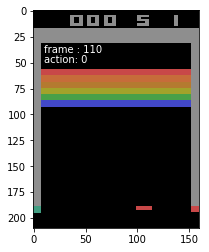

In [8]:
callbacks = []
callbacks = [Visualizer()]

test_hist = dqn.test(env, nb_episodes=1, action_repetition=4,
                     callbacks=callbacks, visualize=False)

# Results

After we have trained everything, we can look at the training history.  First, we save it to a pickle file (note: this will overwrite previous files).  We then plot the `episode_reward` to see how well it performed over each episode.

In [9]:
results = pd.DataFrame(hist.history)
results.to_pickle('hist.pickle')
plt.plot(results['episode_reward'])

KeyError: 'episode_reward'